# Jupyter Notebook of Carlos Moreno Fernandez

Here is the Jupyter Notebook that you can use to run your code. Remember that you data needs to be uploaded to the GitHub repository before you can use it. I recommend you to upload in the folder called *StudentProjects*.

There are a lot of information on how to use Jupyter Notebook on Internet. Here, I will add a small list of actions:
* Use the *Insert* menu to insert new cells
* Use the *Cell/Cell type* menu to change the style of a given cell: *Code* if you want to add Python code and *Markdown* if you want to add an informative cell
* Each cell can be executed individually. Then I recommend to include limited number of code lines in each of them.
* Use the *Edit* menu to delete cells.
* Remember to save your code once you add it.
* If when you run your code, you have errors due to libraries not included in the repository, please contact me.

If you have questions regarding the environment, please email me or use Teams.

In [2]:
# We would require again the following libraries to manage our dataset
# Numpy: used for large, multi-dimensional arrays and matrices, and for high-level mathematical functions
# Pandas: used for data manipulation and analysis
import pandas as pd
import numpy as np
# We will use a new library for machine learning, Scikit-learn. 
# This library allows us to implement easily machine learning models and operations over them. 
# This time we will use the predefined function to scale (min-max normalisation) our data
from sklearn.preprocessing import MinMaxScaler
# we will use the same library to divide our dataset in train and testing
from sklearn.model_selection import train_test_split
# We will import the functions to deal with a linear model.
import sklearn.linear_model as skl_lm
# and a function that calculates the performance
from sklearn.metrics import mean_squared_error
# We will use also another library to plot our model
import matplotlib.pyplot as plt

from matplotlib import pyplot
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
# header: indicates if the dataset has an initial line with the name of each column
dataset = pd.read_csv('Computer-Hardware-Dataset-data-header.csv', header=0)

In [4]:
dataset

,Vendor Name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...,...
204,sperry,80/8,124,1000,8000,0,1,8,42,37
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
206,sratus,32,125,2000,8000,0,2,14,52,41
207,wang,vs-100,480,512,8000,32,0,0,67,47


In [5]:
dataset.head(20)

,Vendor Name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
5,amdahl,470v/b,26,8000,32000,64,8,32,318,290
6,amdahl,580-5840,23,16000,32000,64,16,32,367,381
7,amdahl,580-5850,23,16000,32000,64,16,32,489,381
8,amdahl,580-5860,23,16000,64000,64,16,32,636,749
9,amdahl,580-5880,23,32000,64000,128,32,64,1144,1238


In [6]:
print(dataset.describe())

              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.330144  
std     25.997318   160.830733   154.757102  
min      0.000000     6.000000    15.000000  
25%      5.000000    27.000000    28.000000  
50%      8.000000    50.000000    45.000000  
75%     24.

In [7]:
#Class Distribution
print(dataset.groupby('Vendor Name').size())

Vendor Name
adviser          1
amdahl           9
apollo           2
basf             2
bti              2
burroughs        8
c.r.d            6
cambex           5
cdc              9
dec              6
dg               7
formation        5
four-phase       1
gould            3
harris           7
honeywell       13
hp               7
ibm             32
ipl              6
magnuson         6
microdata        1
nas             19
ncr             13
nixdorf          3
perkin-elmer     3
prime            5
siemens         12
sperry          13
sratus           1
wang             2
dtype: int64


/srv/conda/envs/notebook/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


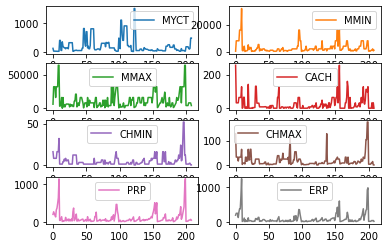

In [8]:
# box and whisker plots
dataset.plot(kind='line', subplots=True, layout=(4,2), sharex=False, sharey=False)
pyplot.show()

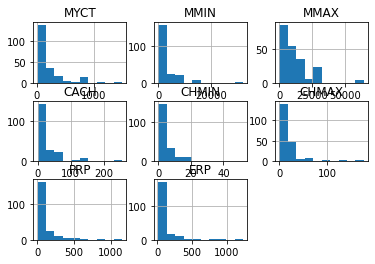

In [9]:
# histograms
dataset.hist()
pyplot.show()

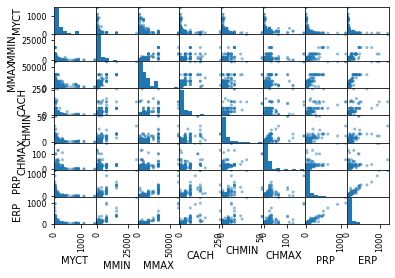

In [10]:
# scatter plot matrix
scatter_matrix(dataset)
pyplot.show()

In [11]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:7]
y = array[:,7]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [13]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'unknown' instead.

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%


(209, 10)


              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.330144  
std     25.997318   160.830733   154.757102  
min      0.000000     6.000000    15.000000  
25%      5.000000    27.000000    28.000000  
50%      8.000000    50.000000    45.000000  
75%     24.

Vendor Name     wang
Model Name     vs-90
MYCT            1500
MMIN           32000
MMAX           64000
CACH             256
CHMIN             52
CHMAX            176
PRP             1150
ERP             1238
dtype: object
Vendor Name    adviser
Model Name         100
MYCT                17
MMIN                64
MMAX                64
CACH                 0
CHMIN                0
CHMAX                0
PRP                  6
ERP                 15
dtype: object


             MYCT        MMIN        MMAX        CACH       CHMIN       CHMAX  \
count  209.000000  209.000000  209.000000  209.000000  209.000000  209.000000   
mean     0.125976    0.087800    0.183498    0.098460    0.090357    0.103795   
std      0.175498    0.121454    0.183411    0.158706    0.131082    0.147712   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.022252    0.022044    0.061562    0.000000    0.019231    0.028409   
50%      0.062711    0.060621    0.124124    0.031250    0.038462    0.045455   
75%      0.140256    0.123246    0.249249    0.125000    0.115385    0.136364   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

              PRP         ERP  
count  209.000000  209.000000  
mean     0.087082    0.068954  
std      0.140586    0.126539  
min      0.000000    0.000000  
25%      0.018357    0.010630  
50%      0.038462    0.024530  
75%      0.093531    0.070319  
max      1.000

Dataset dimension:  (209, 10)
Predictors dimension:  (209, 7)
Target dimension:  (209,)


Predictors dimensions for training:  (146, 7)
Predictors dimensions for testing:  (63, 7)
Target dimensions for training:  (146,)
Target dimensions for testing:  (63,)


SyntaxError: invalid syntax (<ipython-input-46-9936551c4dbf>, line 7)